In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

In [6]:
import warnings
from sklearn.exceptions import DataConversionWarning
# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [7]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [8]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
total_count = len(y)
print("min:",min(np.array(y))[0],"max:",max(np.array(y))[0],"Total:",total_count)


min: 0.0117532464005208 max: 4.9270454514617015 Total: 264


### Visualize Our Data

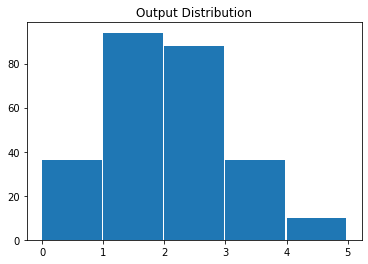

In [9]:
hist, bin_edges = np.histogram(y, bins=5, range=(0,5))
fig = plt.figure()
plt.bar( bin_edges[:-1],hist, width=.98,align="edge")
plt.title("Output Distribution")
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  

# we use r2 because we are doing regression, not classification

class Scorer:
    def __init__(self,X,y):
        self.scores = {}
        self.X = X
        self.y = y
        self.split = 0.25
        self.stratify = np.array(self.y,dtype="int")
        self.iterations = 20
        self.drawer = GraphDrawer()
    
    def set_stratify(self,state):
        if state:
            self.stratify = np.array(self.y,dtype="int")
        else:
            self.stratify = None
        
    def test(self,name,clf,iterations):
        scores = []
        for i in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=self.split,
                                                                random_state=i,stratify=self.stratify)
            clf.fit(X_train,y_train)
            y_predict_tr = clf.predict(X_train)
            y_predict = clf.predict(X_test)    
            scores.append([r2_score(y_train,y_predict_tr),r2_score(y_test,y_predict)])  
        scores = np.array(scores)
        self.scores[name] = [np.mean(scores[:,0]),np.mean(scores[:,1])]

        
    def test_m(self,preds,iterations):
        for predictor in preds:   
            self.test(predictor,preds[predictor],iterations)

    
    def labels(self):
        return [x for x in self.scores]
                        
    def train_scores(self):
        sc = np.array([self.scores[x] for x in self.scores])
        return sc[:,0]
        
    def test_scores(self):
        sc = np.array([self.scores[x] for x in self.scores])
        return sc[:,1]
    
    def draw_scores(self):
        drawer.draw_scores(self)
    
    def clear_scores(self):
        self.scores = {}

In [11]:
class GraphDrawer:
    
    def __init__(self):
        return
        
    def draw_hscores(self,scorer):
        plt.rcdefaults()
        fig, ax = plt.subplots()

        # Example data
        labels = scorer.labels()
        x_pos = np.linspace(0,1,11)
        y_pos = np.arange(len(labels))
        performance = scorer.train_scores()
        width = 0.4  # the width of the bars
        # ax.barh(y_pos, performance, align='center')
        rects1 = ax.barh(y_pos - width/2, scorer.train_scores(), width, label='Train Score')
        rects2 = ax.barh(y_pos + width/2, scorer.test_scores(), width, label='Test Score')
        ax.set_yticks(y_pos)
        ax.set_xticks(x_pos)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()  # labels read top-to-bottom
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                width = rect.get_width()
                i = 0
                if width < 0:
                    i = abs(width)+45
                elif width < 0.1:
                    i = 30
                ax.annotate('{:.3f}'.format(width),
                            xy=(width, rect.get_y() + rect.get_height() / 2),
                            xytext=(i,0),  # 3 points vertical offset
                            textcoords="offset points",
                            va='center', ha='right')
        autolabel(rects1)
        autolabel(rects2)
        fig = plt.gcf()
#         fig.set_size_inches(6,6) 
        ax.set_xlabel('Performance')
        ax.set_title('R2 Scores by Predictors')
        
    def draw_scores(self,scorer):
        if (len(scorer.labels())>=6):
            self.draw_hscores(scorer)
        else:
            x = np.arange(len(scorer.labels()))  # the label locations
    #         y = np.linspace(0,1,11,endpoint=True)
            width = 0.35  # the width of the bars
            fig, ax = plt.subplots()
            rects1 = ax.bar(x - width/2, scorer.train_scores(), width, label='Train Score')
            rects2 = ax.bar(x + width/2, scorer.test_scores(), width, label='Test Score')
            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('R2 Scores')
            ax.set_title('R2 Scores by Predictors')
            ax.set_xticks(x)
    #         ax.set_yticks(y)
            ax.set_xticklabels(scorer.labels())
            ax.legend()

            def autolabel(rects):
                """Attach a text label above each bar in *rects*, displaying its height."""
                for rect in rects:
                    height = rect.get_height()
                    i = 0
                    if height < 0:
                        i = abs(height)+10
                    ax.annotate('{:.3f}'.format(height),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 1+i),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

            autolabel(rects1)
            autolabel(rects2)
            fig = plt.gcf()
#             fig.set_size_inches(7,6)        
            plt.show()
    
    
               
    def plot_graph(self,y,y_pred,title):
        fig, ax = plt.subplots()
        plt.axis([0,5,0,5])
        ax.set_title(title)
        plt.plot(y,y_pred,'o',color="black")
        plt.plot([x for x in np.arange(0,6)],[x for x in np.arange(0,6)],'r--',)
        plt.show()
    

In [12]:
scorer = Scorer(X,y)
drawer = GraphDrawer()

### v0: Raw Scores

In [13]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor


xgb_0 = XGBRegressor()
svr_0 = SVR()
rfr_0 = RandomForestRegressor()
ada_0 = AdaBoostRegressor()


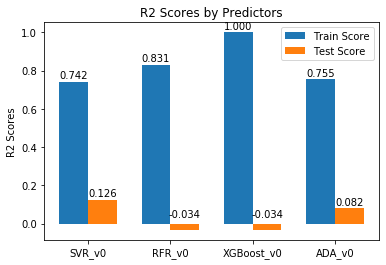

In [14]:
scorer.clear_scores()
scorer.set_stratify(False)
scorer.test("SVR_v0",svr_0,15)
scorer.test("RFR_v0",rfr_0,15)
scorer.test("XGBoost_v0",xgb_0,15)
scorer.test("ADA_v0",ada_0,15)
scorer.draw_scores()

### v0.5 Stratify the Data
Added on May 27, 2020
    
    
    

#### Take this simple step to stratify our data...

In [ ]:
y_stf = np.array(y,dtype="int")

In [44]:
#print out the first 10 elements for visualization purposes
data = {"Stratified data":list(y_stf.ravel())}
df1 = pd.DataFrame(data = data,columns=["Stratified data"])
df1["Original data"]=raw_data["output"]
df1.head(10)

,Stratified data,Original data
0,2,2.516485
1,1,1.640909
2,0,0.416348
3,1,1.338558
4,1,1.729517
5,2,2.704476
6,1,1.971622
7,1,1.843582
8,2,2.082107
9,2,2.898305


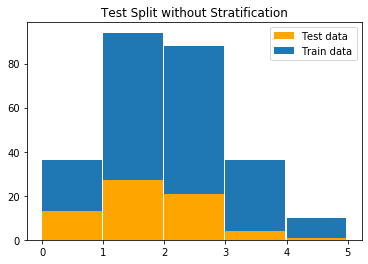

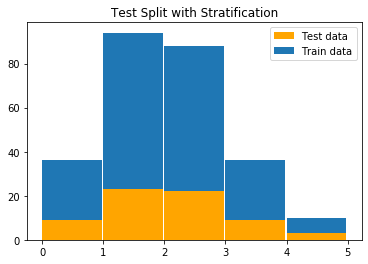

In [47]:

def stratify_demo(title,scorer,split):
    #Without Stratification
    X_train, X_test, y_train, y_test = train_test_split(scorer.X,scorer.y,test_size=split,
                                                        random_state=1,stratify = scorer.stratify)
    hist_tr, bin_edges_tr = np.histogram(y_train, bins=5, range=(0,5))
    hist_test, bin_edges_test = np.histogram(y_test, bins=5, range=(0,5))
    fig,ax = plt.subplots()
    ax.bar( bin_edges_test[:-1],hist_test, width=.98,align="edge",color="orange",label="Test data")
    ax.bar( bin_edges_tr[:-1],hist_tr, width=.98,align="edge",bottom=hist_test,label="Train data")
    ax.set_title(title)
    ax.legend()

split = 0.25
scorer.set_stratify(False)
stratify_demo("Test Split without Stratification",scorer,split)
scorer.set_stratify(True)
stratify_demo("Test Split with Stratification",scorer,split)


#With Stratification


In [48]:
scorer.set_stratify(True)
svr_05 = SVR()
rfr_05 = RandomForestRegressor()
xgb_05 = XGBRegressor()
ada_05 = AdaBoostRegressor()


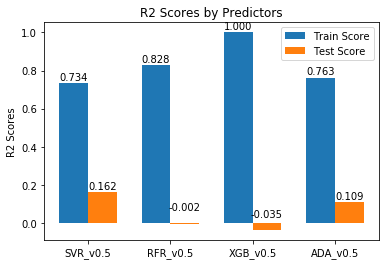

In [49]:
scorer.clear_scores()
scorer.test("SVR_v0.5",svr_05,15)
scorer.test("RFR_v0.5",rfr_05,15)
scorer.test("XGB_v0.5",xgb_05,15)
scorer.test("ADA_v0.5",ada_05,15)

scorer.draw_scores()

### v1.0: Use Grid Search

In [50]:
def find_best_params(scorer,clf,grid):
    X_train, X_test, y_train, y_test = train_test_split(scorer.X,scorer.y,test_size=scorer.split,
                                                    stratify=scorer.stratify)
    gd_sr = GridSearchCV(estimator=clf,
                           param_grid=grid,
                           scoring='r2', # note the use of scoring here.
                           cv=5, iid=False)
    gd_sr.fit(X_train, y_train)
    return gd_sr.best_params_

def grid(name):
    grid = {'SVR':{'kernel':['rbf'],'degree':[1],'gamma':['scale'],
           'coef0':[-50],'tol':[0.01],'C':[5],'epsilon':[0.1], 
           'shrinking':[True],'cache_size':[50],'verbose':[False],
           'max_iter':[-1]},
            'RFR':{'n_estimators':[100],
        'criterion':['mse'], #'mae'
        'max_depth':[None],
        'min_samples_split':[15],
        'min_samples_leaf':[5],
        'min_weight_fraction_leaf':[0.0],
        'max_features':["sqrt"], #,"log2",'auto'
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'bootstrap':[True],
        'oob_score':[False],
        'n_jobs':[None],
        'random_state':[None],
        'verbose':[0],
        'warm_start':[True]
       }
#             'ADA':{    'base_estimator':[None],
#     n_estimators=50,
#     learning_rate=1.0,
#     loss='linear',
#     random_state=None,}
                }
    return grid[name]

def best(name):
    best = { 
        'SVR':SVR(kernel='rbf',
               degree=1,
               gamma='scale',
               coef0=-50,
               tol=0.01,
               C=5,
               epsilon=0.1,
               shrinking=True,
               cache_size=50,
               verbose=False),
        'RFR':RandomForestRegressor(
                n_estimators=100,
                criterion='mse',
                max_depth=None,
                min_samples_split=15,
                min_samples_leaf=5,
                min_weight_fraction_leaf=0.0,
                max_features='sqrt',
                max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                min_impurity_split=None,
                bootstrap=True,
                oob_score=False,
                n_jobs=None,
                random_state=None,
                verbose=0,
                warm_start=False,),
        'XGBoost':XGBRegressor(),
        'ADA':AdaBoostRegressor(    
                base_estimator=None,
                n_estimators=100,
                learning_rate=1.0,
                loss='linear',
                random_state=None,)}
    return best[name]



In [51]:
ADA = {    'base_estimator':[None],
    'n_estimators':[100],
    'learning_rate':[1.0],
    'loss':['linear']}

ada_1 = AdaBoostRegressor()
find_best_params(scorer,ada_1,ADA)

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 100}

In [52]:
svr_10 =  best("SVR")
rfr_10 =  best("RFR")
ada_10 = best("ADA")


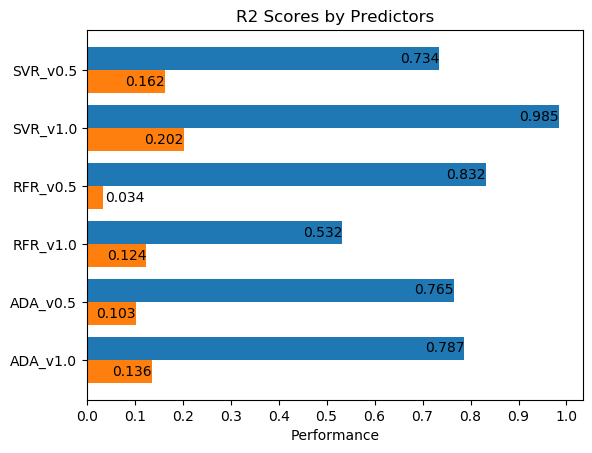

In [53]:
scorer = Scorer(X,y)
scorer.set_stratify(True)
scorer.test("SVR_v0.5",svr_05,15)
scorer.test("SVR_v1.0",svr_10,15)
scorer.test("RFR_v0.5",rfr_05,15)
scorer.test("RFR_v1.0",rfr_10,15)
scorer.test("ADA_v0.5",ada_05,15)
scorer.test("ADA_v1.0",ada_10,15)
scorer.draw_scores()

### v1.1 Use SelectKBest 

In [54]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

def FS(scorer,fs,name,clf,split,iterations):
    scores = []
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(scorer.X,scorer.y,test_size=scorer.split,
                                                            random_state=i,stratify=scorer.stratify)
        X_train_FS, X_FS, y_train_FS, y_FS = train_test_split(X_train,y_train, test_size=split)
        fs.fit(X_FS,y_FS)
        X_train_FS = fs.transform(X_train_FS)
        X_test_FS = fs.transform(X_test)
        clf.fit(X_train_FS,y_train_FS)
        y_predict_tr = clf.predict(X_train_FS)
        y_predict = clf.predict(X_test_FS)    
        scores.append([r2_score(y_train_FS,y_predict_tr),r2_score(y_test,y_predict)])  
    scores = np.array(scores)
    scorer.scores[name] = [np.mean(scores[:,0]),np.mean(scores[:,1])]
    
def FS_test(scorer,fs,name,clf,split,iterations,num_features):
    scorer.test(name,clf,iterations)
    for k in num_features:
        if fs == "KBest": 
            fs = SelectKBest(f_regression, k=k)
        elif fs == "RFE":
            fs = RFE(clf, n_features_to_select=k, step=.2)            
        FS(scorer,fs,name+"_"+str(k),clf,split,iterations)

num_features = [300,500,700,900]

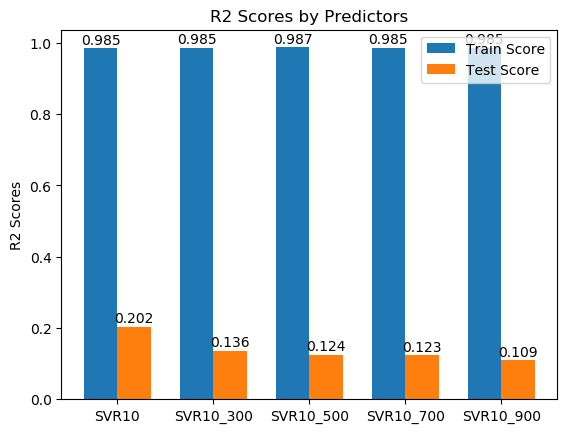

In [55]:
scorer = Scorer(X,y)
FS_test(scorer,"KBest","SVR10",svr_10,split=0.25,iterations=15,num_features=num_features)
scorer.draw_scores()

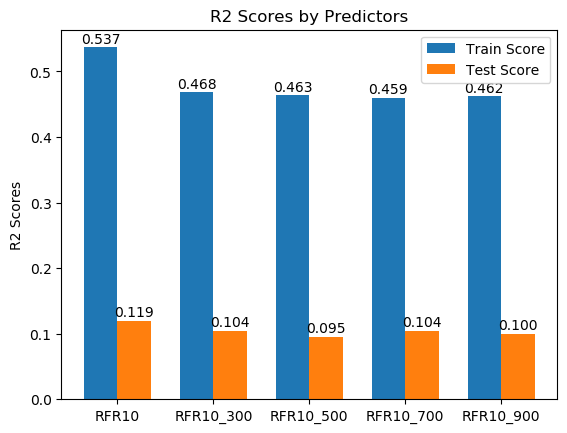

In [57]:
scorer = Scorer(X,y)
FS_test(scorer,"KBest","RFR10",rfr_10,split=0.25,iterations=15,num_features=num_features)
scorer.draw_scores()

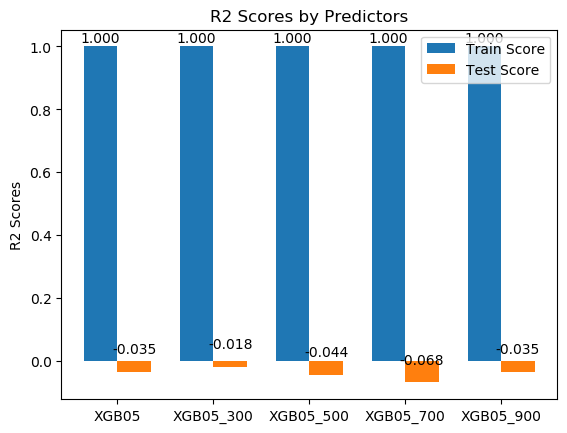

In [58]:
scorer = Scorer(X,y)
FS_test(scorer,"KBest","XGB05",xgb_05,split=0.25,iterations=15,num_features=num_features)
scorer.draw_scores()

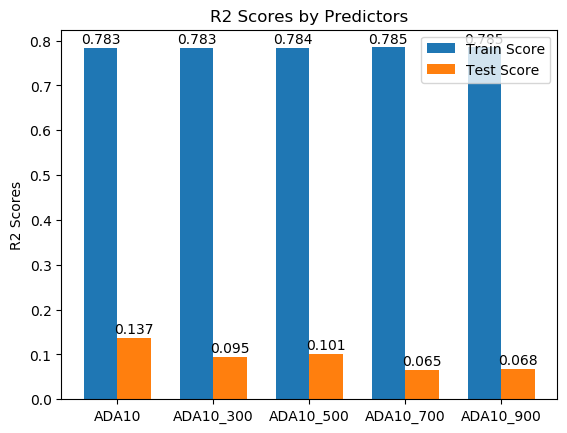

In [59]:
scorer = Scorer(X,y)
FS_test(scorer,"KBest","ADA10",ada_10,split=0.25,iterations=15,num_features=num_features)
scorer.draw_scores()

### v1.2 Try Feature Selection with RFE

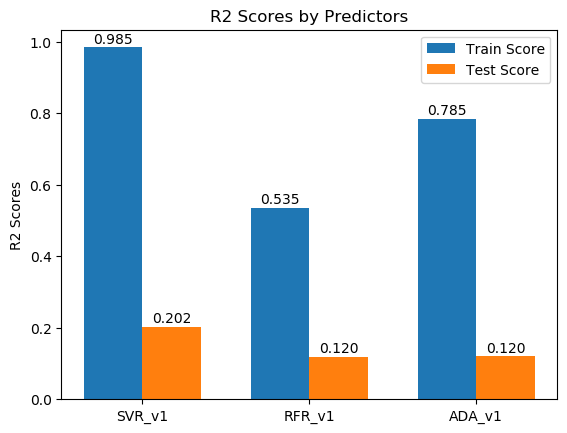

In [60]:
scorer = Scorer(X,y)
scorer.test_m({'SVR_v1':svr_10,'RFR_v1':rfr_10,'ADA_v1':ada_10},15)
scorer.draw_scores()

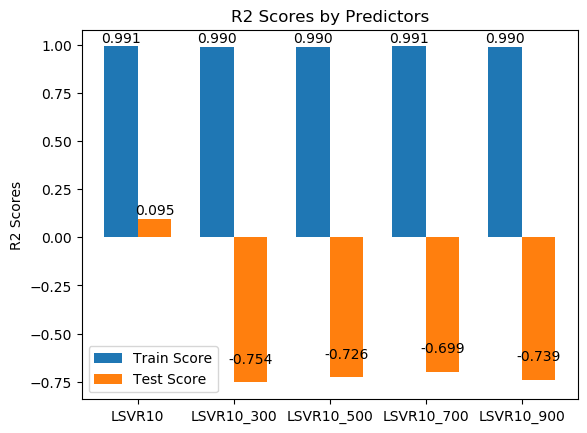

In [61]:
scorer = Scorer(X,y)
svr_12 = SVR(kernel = 'linear')
FS_test(scorer,"RFE","LSVR10",svr_12,0.18,15,num_features=num_features)
scorer.draw_scores()

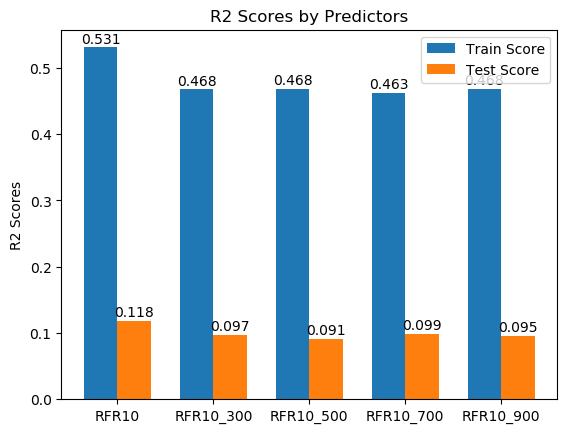

In [62]:
scorer.clear_scores()
FS_test(scorer,"RFE","RFR10",rfr_10,0.2,15,num_features=num_features)
scorer.draw_scores()

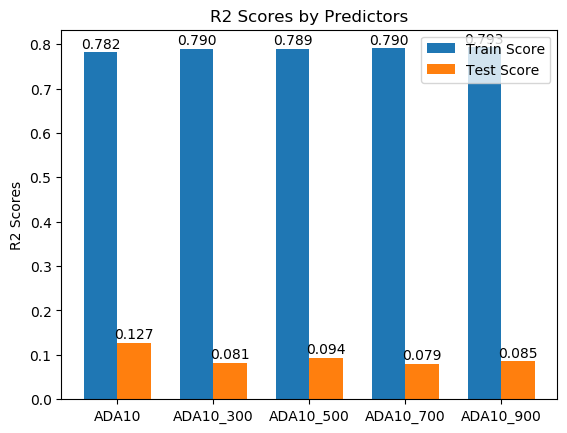

In [63]:
scorer.clear_scores()
FS_test(scorer,"RFE","ADA10",ada_10,0.2,15,num_features=num_features)
scorer.draw_scores()

### v1.2.1 Dig deeper into AdaBoost

In [68]:
num_features = [75*i for i in range(1,10)]


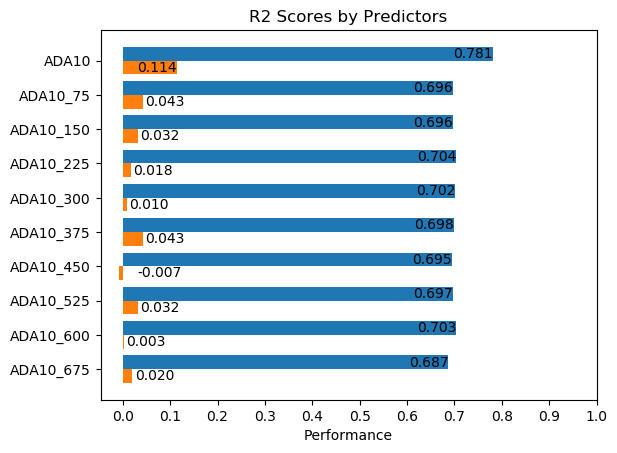

In [69]:
scorer.clear_scores()
FS_test(scorer,"RFE","ADA10",ada_10,0.2,15,num_features=num_features)
scorer.draw_scores()